In [1]:
# using an XGBoost model, the goal is to predict lap times
# TRAINING DATA: all data ingested from the 2024 season

In [ ]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data Gathering/Preprocessing

In [3]:
# pull the lap times data and race conditions data
lap_data = pd.read_csv("../data/lap_time_df.csv")
weather_data = pd.read_csv("../data/race_conditions_df.csv")

In [4]:
# merge the two dataframes
data = lap_data.merge(
    weather_data,
    on="race_id",
    how="left"
)

# create a boolean column for rain
data["is_rain"] = data["rain"].astype(int)

# convert categorical columns (compound, track)
# compound (one hot encoding)
compound_ohe = pd.get_dummies(
    data["compound"],
    prefix="compound"
)

final_df = pd.concat([data, compound_ohe], axis=1)

# track (target encoding -> each track has roughly the same lap time per track)  MAKE SURE THERE IS NO DATA LEAKAGE (split train/test first then apply)
# WHAT IS TARGET ENCODING -> this is taking a categorical column and replacing it with some numerical value derived from that column
# NOTE: track x will always have lap times around 0-1 and then track y will always have lap times around 1-2 (for example)


In [5]:
final_df.columns

Index(['race_id', 'year', 'round', 'track', 'driver', 'team', 'race_lap',
       'stint', 'compound', 'tire_age', 'lap_time_sec', 'is_inlap',
       'is_outlap', 'circuit_length(km)', 'track_temp', 'air_temp', 'rain',
       'is_rain', 'compound_HARD', 'compound_INTERMEDIATE', 'compound_MEDIUM',
       'compound_SOFT', 'compound_WET'],
      dtype='object')

In [65]:
# target encode track column
# split the final_df before encoding to prevent data leakage
# train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=44, shuffle=True)   # SPLITTING ISSUE (splits per row instead of per race -> context leakage (predicting later laps instead of future laps))
unique_races = final_df["race_id"].unique()

train_races, test_races = train_test_split(
    unique_races,
    test_size=0.2,
    # random_state=44,
    # shuffle=True
)

train_df = final_df[final_df["race_id"].isin(train_races)].copy()
test_df  = final_df[final_df["race_id"].isin(test_races)].copy()


# kfold target encoding helper function
def kfold_target_encode(df, cat_col, target_col, n_splits=5):
    df = df.copy()
    kf = KFold(n_splits=n_splits)

    # find a numerical feature to represent track
    global_mean = df[target_col].mean()
    encoded = pd.Series(index=df.index, dtype=float)

    for train_idx, val_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]

        means = train_fold.groupby(cat_col)[target_col].mean()
        encoded.iloc[val_idx] = val_fold[cat_col].map(means)

    # have a fallback for unseen categories
    encoded.fillna(global_mean, inplace=True)

    return encoded


# apply helper function to the training track column
train_df["track_te"] = kfold_target_encode(
    train_df, 
    "track",
    "lap_time_sec"
)

# apply encoding into the test data
track_means = train_df.groupby("track")["lap_time_sec"].mean()
global_mean = train_df["lap_time_sec"].mean()

test_df["track_te"] = (
    test_df["track"]
    .map(track_means)
    .fillna(global_mean)
)

# # after all encodings drop all categorical columns
# train_df = train_df.drop(columns=["rain", "track"])
# test_df = test_df.drop(columns=["rain", "track"])

In [66]:
# NOTE: because rows are grouped together (i.e. row 1 = lap 3 of bahrain and row 2 = lap 4) so randomly splitting these would hurt our analysis
X_train = train_df[["race_lap", "tire_age", "stint", "track_temp", "air_temp", "is_rain", "track_te", "compound_HARD", "compound_INTERMEDIATE", "compound_MEDIUM", "compound_SOFT", "compound_WET"]]  # still need to target encode "track"
y_train = train_df["lap_time_sec"]

X_test = test_df[["race_lap", "tire_age", "stint", "track_temp", "air_temp", "is_rain", "track_te", "compound_HARD", "compound_INTERMEDIATE", "compound_MEDIUM", "compound_SOFT", "compound_WET"]]  # still need to target encode "track"
y_test = test_df["lap_time_sec"]

## Data Visualizations

In [67]:
import seaborn as sns

Text(0.5, 1.0, 'Tire Age vs Lap Time')

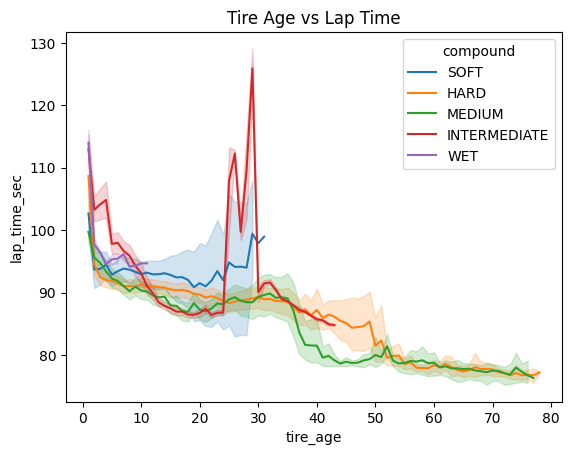

In [68]:
# plot tire age vs lap time sec (colored by compound)
# GOAL: should see that degradation still exists (if there is no then I over encoded)
sns.lineplot(data=train_df, x="tire_age", y="lap_time_sec", hue="compound")
plt.title("Tire Age vs Lap Time")

Text(0.5, 1.0, 'Lap Time Model Input Correlations')

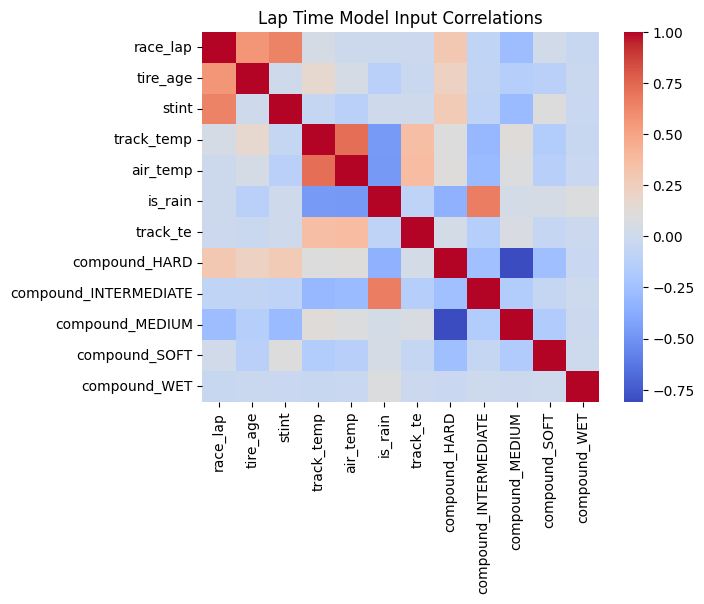

In [69]:
sns.heatmap(X_train.corr(), cmap="coolwarm")
plt.title("Lap Time Model Input Correlations")

## Model Building

In [70]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

[0]	train-rmse:11.55459	test-rmse:13.31057


[50]	train-rmse:7.38619	test-rmse:12.32049
[100]	train-rmse:5.99723	test-rmse:12.11605
[118]	train-rmse:5.65546	test-rmse:12.12141
RMSE: 12.121414641809533
R2: 0.1734110104181008


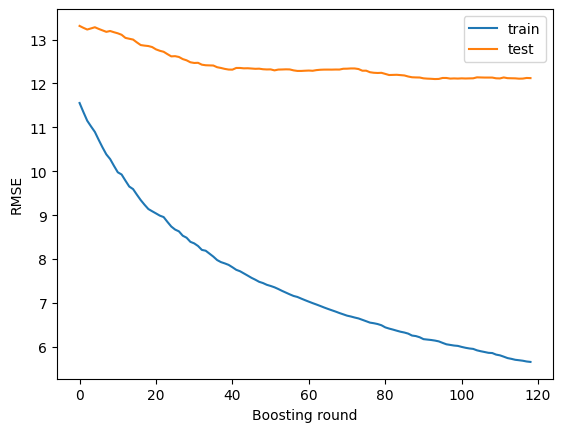

In [71]:
# build DMatrix structures to allow faster training and less memory use for the XGB model
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

# define parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.03,
    "max_depth": 3,
    "min_child_weight": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "lambda": 5.0,   # L2
    "alpha": 1.0,    # L1
    "seed": 42
}

evals = [(xgb_train, "train"), (xgb_test, "test")]

# IMPORTANT: pass a dict to collect evaluation results
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=25,
    evals_result=evals_result,
    verbose_eval=50
)

# predictions
preds = model.predict(xgb_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

# plot learning curves
plt.plot(evals_result["train"]["rmse"], label="train")
plt.plot(evals_result["test"]["rmse"], label="test")
plt.xlabel("Boosting round")
plt.ylabel("RMSE")
plt.legend()
plt.show()


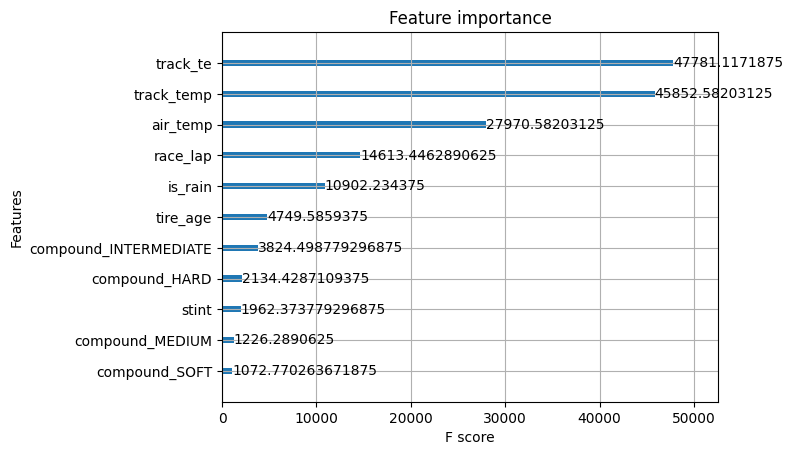

In [72]:
xgb.plot_importance(model, importance_type="gain", max_num_features=15)
plt.show()

## Model Optimization